In [1]:
# General Dependencies
import timeit, os
import numpy as np
import scipy.io as io

# Preprocessing Dependencies
from trefide.utils import psd_noise_estimate

# PMD Model Dependencies
from trefide.pmd import batch_decompose, batch_recompose, overlapping_batch_decompose, overlapping_batch_recompose

# Plot & Video Dependencies
import mpdf_plot
import matplotlib.pyplot as plt
import mpdf_plot

# Plots
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot
from trefide.video import write_mpl, play_cv2

%load_ext autoreload
%autoreload 2

# Set Parameters

In [2]:
max_components = 50
max_iters_main = 40
max_iters_init = 10
consec_failures = 3
d_sub=2
t_sub=2
tol = 5e-3
ext = "../trefide"

# Tolias 3P

In [3]:
# Set Data Information
dataset = "3P"
filename = os.path.join(ext, "data", "18252_5_00006_00001_trimmed_d2_v1_rig_10.npz")
block_height = 40
block_width = 28

In [4]:
mov = np.load(filename)['data'].astype(np.float64).copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Preprocess

In [5]:
# Remove Any Nan Pixels
mov[np.isnan(mov)] = 0

# Remove Movie-Wise Median
mov -= np.median(mov)

# Normalize By Pixelwise Standard Deviation
pixelwise_std = np.reshape(np.sqrt(psd_noise_estimate(np.reshape(mov, (num_pixels, num_frames)))),
                           (fov_height, fov_width, 1))
mov /= pixelwise_std
mov[np.isnan(mov)] = 0

## Run Decomposition

In [6]:
# Perform 4x Overlapping Blockwise PMD In Parallel
spatial_components,\
temporal_components,\
block_ranks,\
block_indices,\
block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                            mov, block_height, block_width,
                                            max_components, consec_failures,
                                            max_iters_main, max_iters_init, tol,
                                            d_sub=d_sub, t_sub=t_sub)

# Use Compressed Components To Reconstruct Denoise Video
mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                      block_height, block_width,
                                                      spatial_components,
                                                      temporal_components,
                                                      block_ranks,
                                                      block_indices,
                                                      block_weights)) 

## Run Timing Evaluation

In [7]:
def time_dec_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)

timeit.timeit(time_dec_pmd, number=5)/5

29.16268515720003

## Postprocessing

In [8]:
# Crop Problematic Border
mov = mov[20:-20,20:-20,:]
mov_denoised = mov_denoised[20:-20,20:-20,:]

## Produce Performance Diagnostics

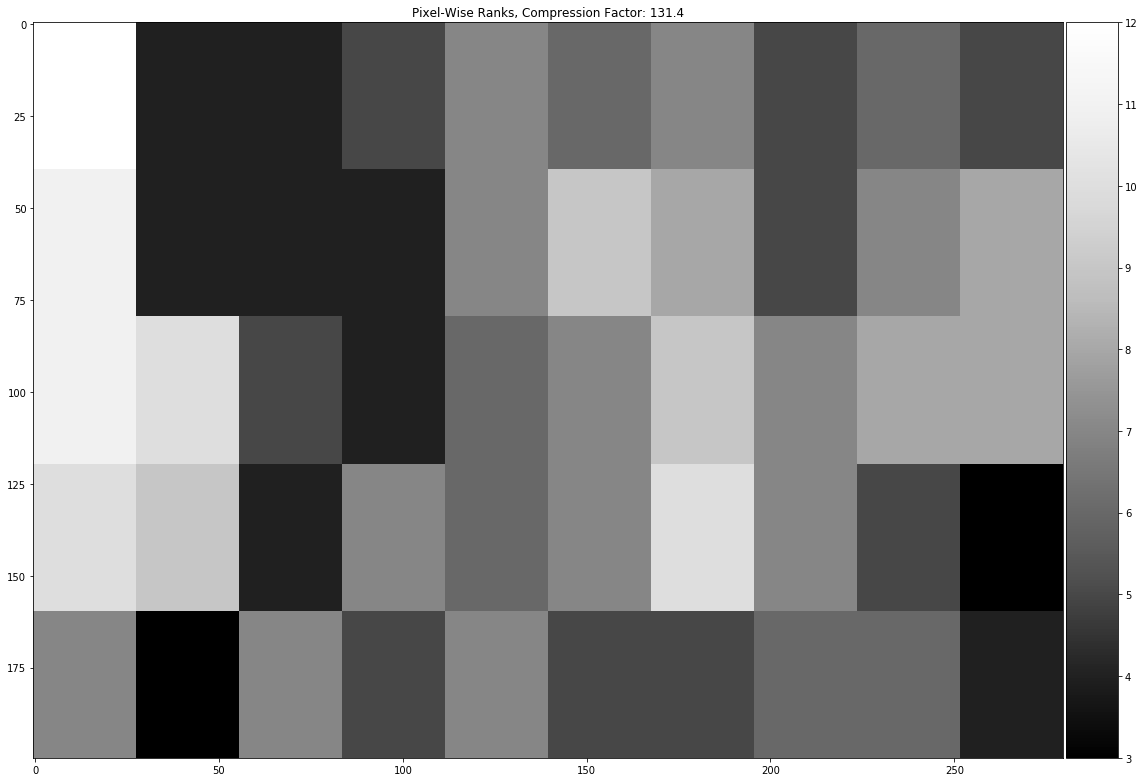

In [9]:
pixelwise_ranks(block_ranks['no_skew']['full'], 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [3.7e-02 2.3e-01]
Local correlation:  range [-3.1e-01 9.9e-01]
Local correlation:  range [-2.2e-02 1.4e-01]


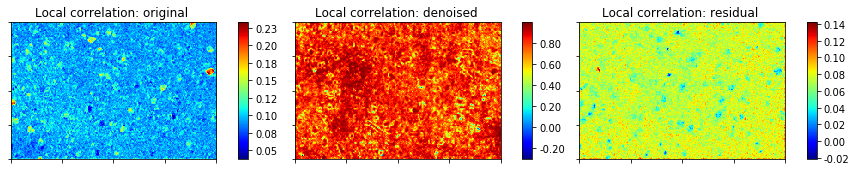

In [10]:
comparison_plot([mov, mov_denoised], plot_orientation="vertical")

## Generate Paper Figs

In [11]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks['no_skew']['full'],
                    pixel_coor1=[94, 2],
                    pixel_coor2=[98, 4],
                    frame_idx=590,
                    trace_seg=[0, 800],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='3P_PMD.pdf')
plt.show()

Single Frame:  range [-1.7e+00 7.7e+00]
Single Frame:  range [-7.8e-01 4.1e+00]
Single Frame:  range [-3.6e+00 7.3e+00]
SNR:  range [1.1e+00 1.4e+00]
SNR:  range [1.3e+00 5.8e+00]
SNR:  range [1.1e+00 1.3e+00]
Local correlation:  range [4.6e-02 2.1e-01]
Local correlation:  range [5.6e-03 1.4e-01]


# Q-State Bio Voltage Imaging

In [12]:
# Set Data Information
dataset = "Voltage"
filename = os.path.join(ext, "data", "denoised_IE017.npz")
block_height = 40
block_width = 40

In [13]:
mov = np.load(filename)['arr_0'].astype(np.float64).copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Run Decomposition

In [14]:
# Perform 4x Overlapping Blockwise PMD In Parallel
spatial_components,\
temporal_components,\
block_ranks,\
block_indices,\
block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                            mov, block_height, block_width,
                                            max_components, consec_failures,
                                            max_iters_main, max_iters_init, tol,
                                            d_sub=d_sub, t_sub=t_sub)

# Use Compressed Components To Reconstruct Denoise Video
mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                      block_height, block_width,
                                                      spatial_components,
                                                      temporal_components,
                                                      block_ranks,
                                                      block_indices,
                                                      block_weights)) 

## Run Timing Evaluation

In [15]:
def time_dec_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)

timeit.timeit(time_dec_pmd, number=5)/5

44.98296180660036

## Produce Performance Diagnostics

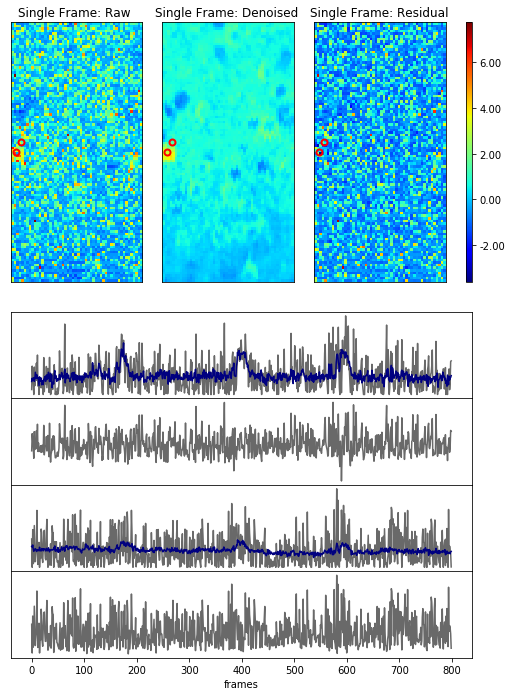

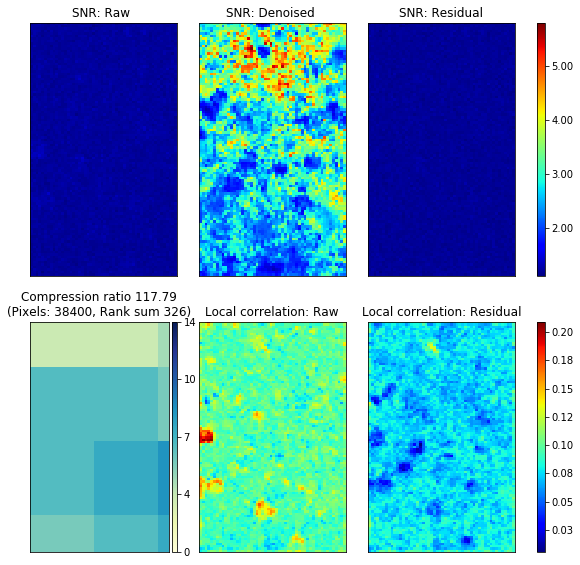

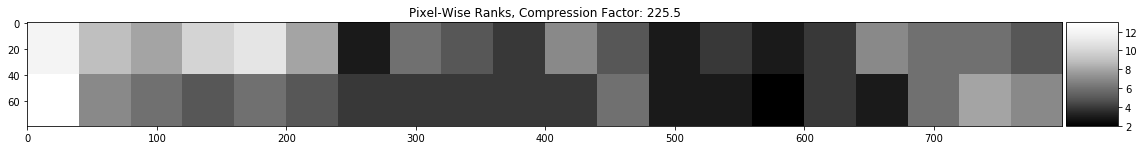

In [16]:
pixelwise_ranks(block_ranks['no_skew']['full'],
                fov_height, fov_width,
                num_frames, block_height, block_width)

Local correlation:  range [-1.9e-02 8.6e-01]
Local correlation:  range [-8.4e-01 1.0e+00]
Local correlation:  range [-7.5e-02 9.3e-02]


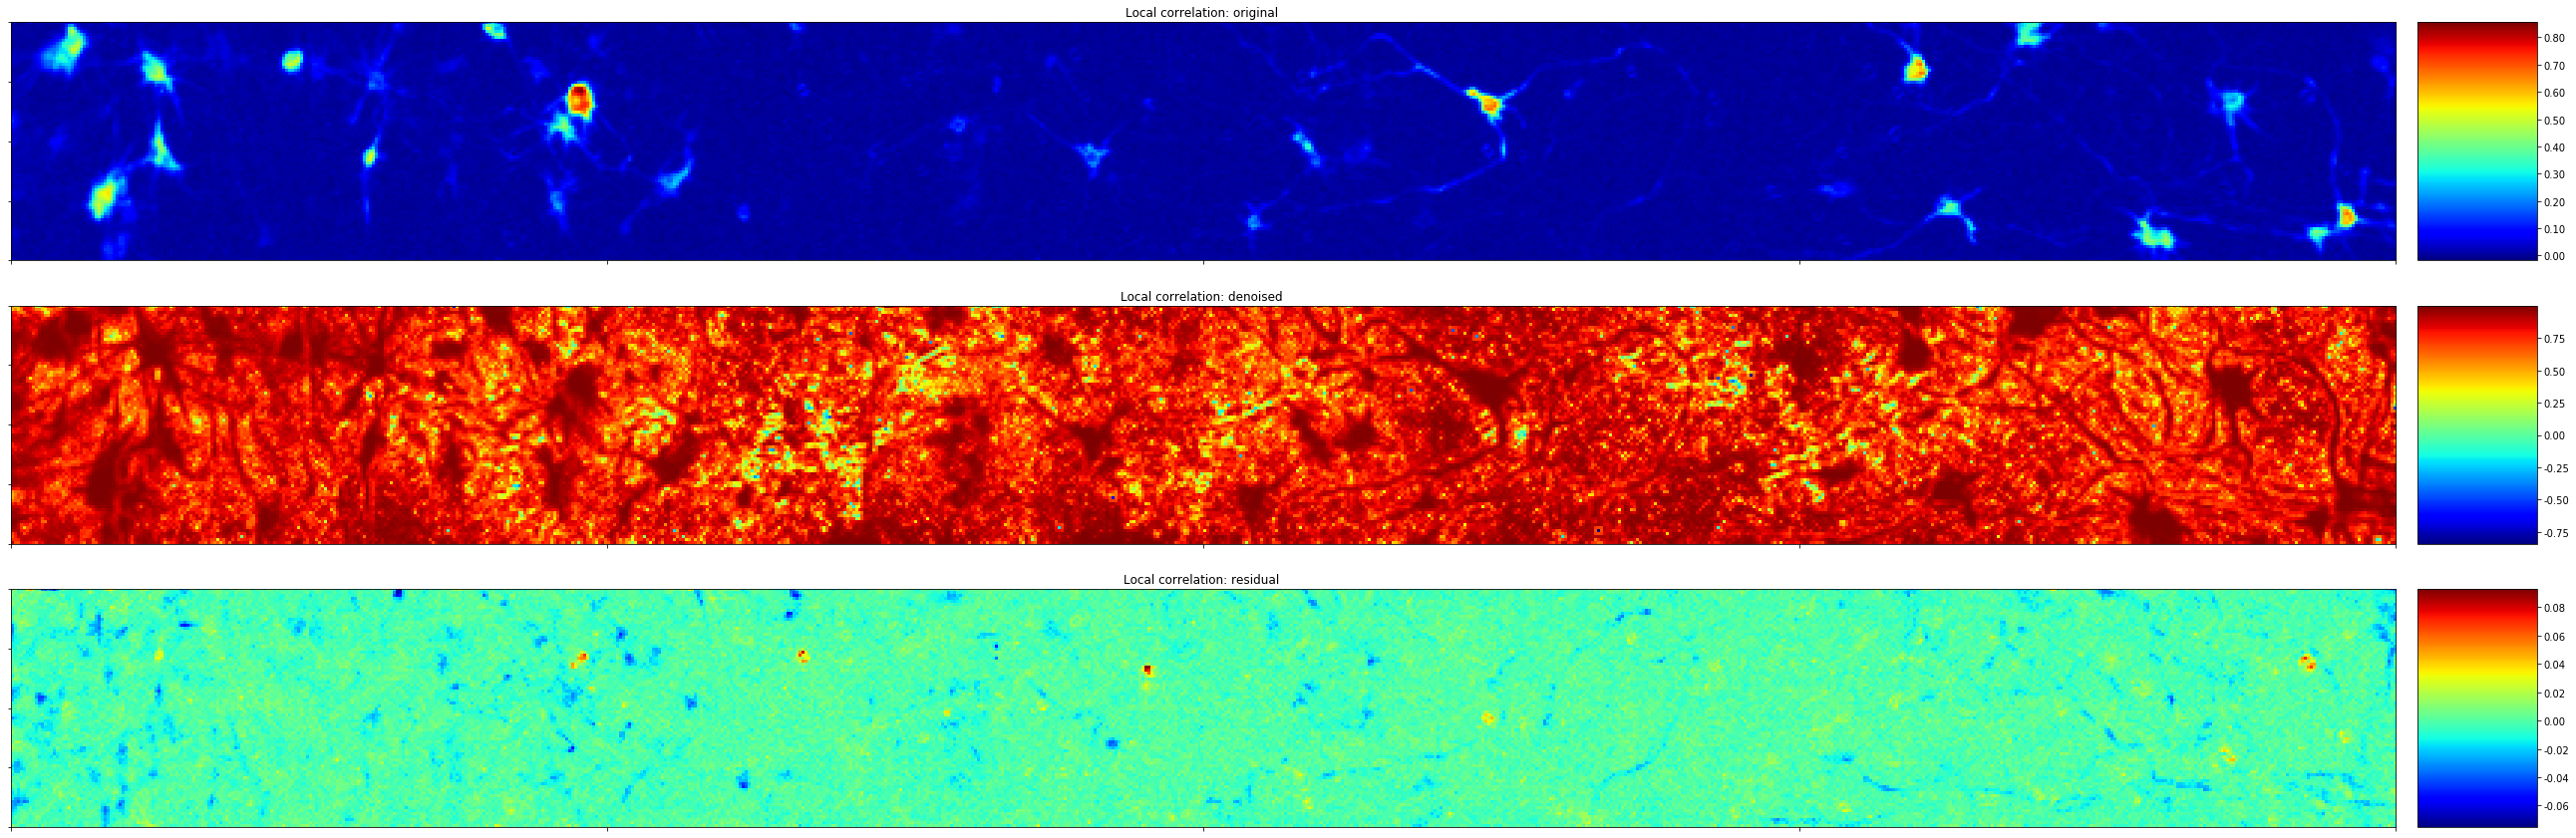

In [17]:
comparison_plot([mov, mov_denoised], plot_orientation="horizontal")

## Generate Paper Figs

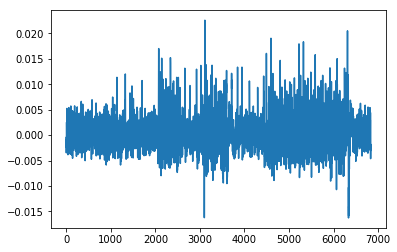

In [18]:
plt.plot(np.arange(num_frames), mov_denoised[73,785,:])
plt.show()

Single Frame:  range [-1.1e-01 1.3e-01]
Single Frame:  range [-1.4e-02 2.1e-02]
Single Frame:  range [-1.1e-01 1.3e-01]
SNR:  range [1.1e+00 2.2e+00]
SNR:  range [1.2e+00 8.1e+00]
SNR:  range [1.1e+00 1.3e+00]
Local correlation:  range [-1.5e-02 6.7e-01]
Local correlation:  range [-3.5e-02 7.2e-02]


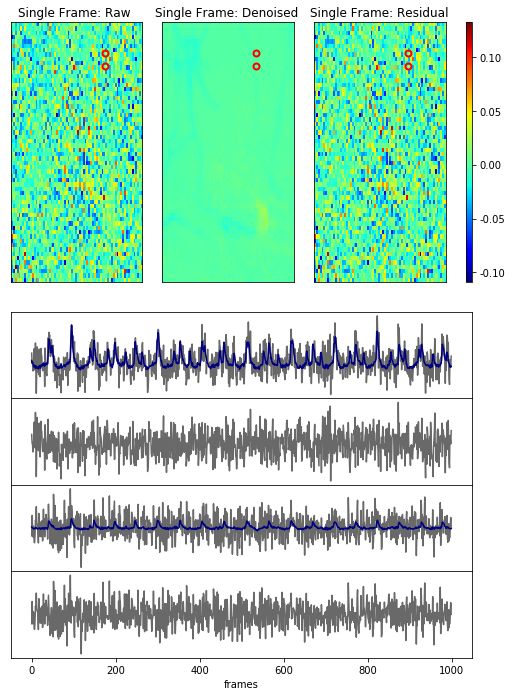

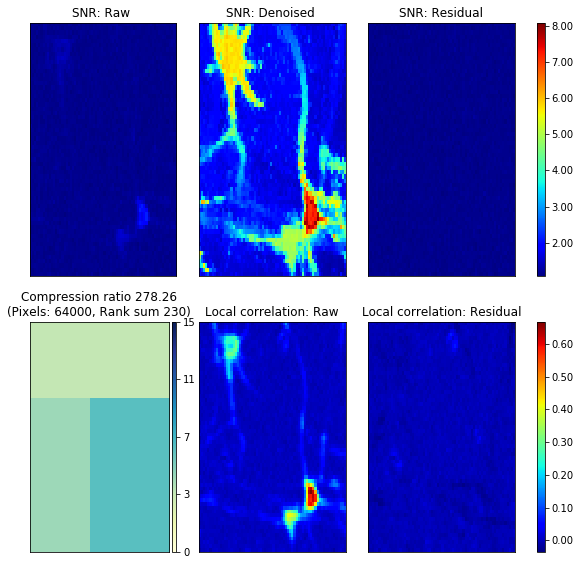

In [19]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks['no_skew']['full'],
                    pixel_coor1=[70, 780],
                    pixel_coor2=[73, 780],
                    frame_idx=4500,
                    trace_seg=[4500,5500],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='QState_PMD.pdf')
plt.show()

# Widefield

In [20]:
dataset = "Widefield"
filename = os.path.join(ext, "data", "hillman_stim1.npz")
block_height = 64
block_width = 64

In [21]:
mov = np.load(filename)['data'].astype(np.float64)[:,:,:-1].copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Preprocess

In [22]:
# Remove Any Nan Pixels
mov[np.isnan(mov)] = 0

# Remove Movie-Wise Median
mov -= np.median(mov)

# Normalize By Pixelwise Standard Deviation
pixelwise_std = np.reshape(np.sqrt(psd_noise_estimate(np.reshape(mov, (num_pixels, num_frames)))),
                           (fov_height, fov_width, 1))
mov /= pixelwise_std
mov[np.isnan(mov)] = 0

/home/ian/miniconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ian/miniconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Run Decomposition

In [23]:
# Perform 4x Overlapping Blockwise PMD In Parallel
spatial_components,\
temporal_components,\
block_ranks,\
block_indices,\
block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                            mov, block_height, block_width,
                                            max_components, consec_failures,
                                            max_iters_main, max_iters_init, tol,
                                            d_sub=d_sub, t_sub=t_sub)

# Use Compressed Components To Reconstruct Denoise Video
mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                      block_height, block_width,
                                                      spatial_components,
                                                      temporal_components,
                                                      block_ranks,
                                                      block_indices,
                                                      block_weights)) 

## Run Timing Evaluation

In [24]:
def time_dec_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)

timeit.timeit(time_dec_pmd, number=5)/5

21.032290796800226

## Produce Performance Diagnostics

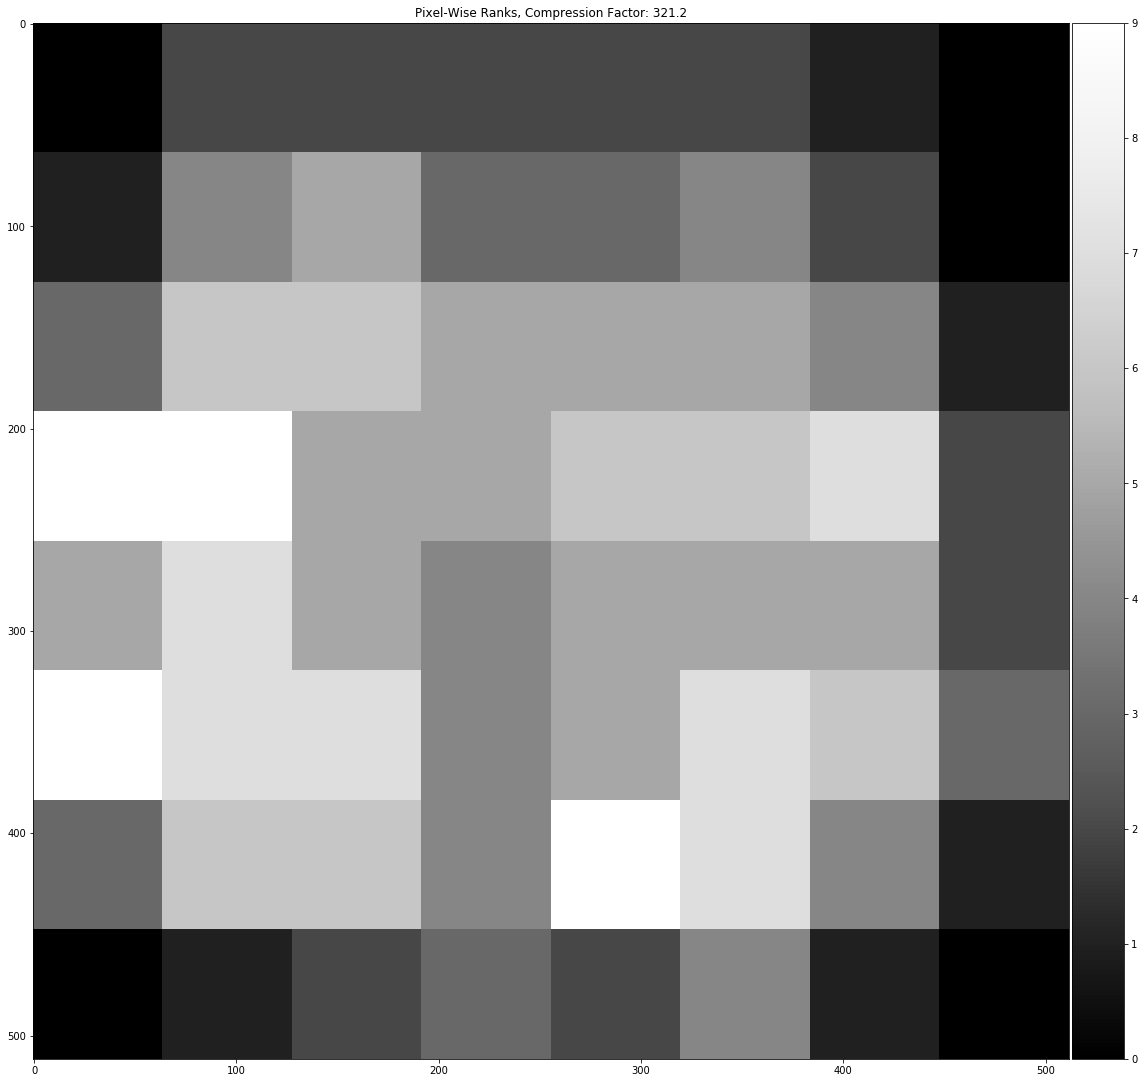

In [25]:
pixelwise_ranks(block_ranks['no_skew']['full'], 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [-3.9e-02 8.8e-01]
Local correlation:  range [-2.1e-01 1.0e+00]
Local correlation:  range [-6.8e-02 4.1e-01]


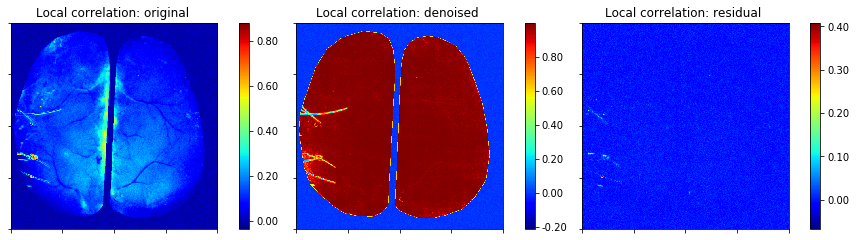

In [26]:
comparison_plot([mov + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01,
                 mov_denoised + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01], plot_orientation="vertical")

## Generate Paper Figs

Single Frame:  range [-3.4e+00 4.2e+00]
Single Frame:  range [-2.1e-01 3.2e-01]
Single Frame:  range [-3.3e+00 4.1e+00]
SNR:  range [1.1e+00 1.5e+00]
SNR:  range [2.3e+00 7.2e+00]
SNR:  range [1.1e+00 1.4e+00]
Local correlation:  range [1.8e-02 2.1e-01]
Local correlation:  range [-3.5e-02 3.4e-02]


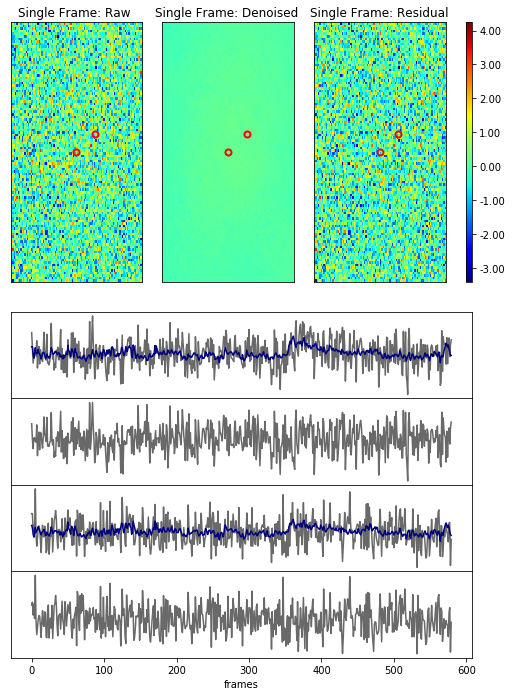

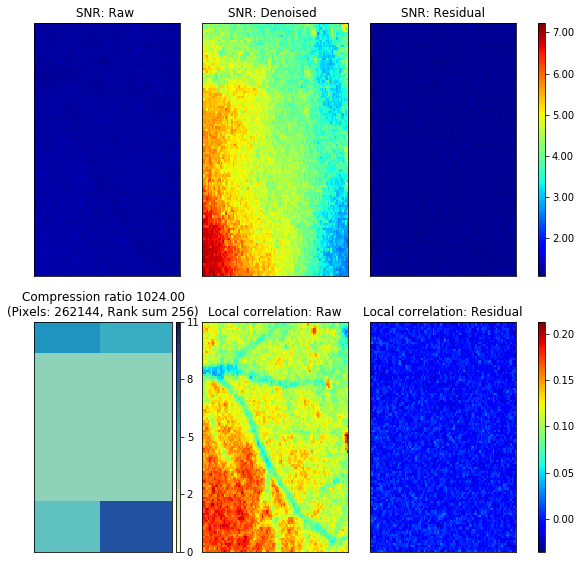

In [27]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks['no_skew']['full'],
                    pixel_coor1=[228, 386],
                    pixel_coor2=[235, 400],
                    frame_idx=569,
                    trace_seg=[220,800],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='Widefield_PMD.pdf')
plt.show()

# Endoscope

In [28]:
# Set Data Information
dataset = "Endoscope"
filename = os.path.join(ext, "data", "pc_blood_vessel_10Hz.npz")
block_height = 16
block_width = 16

In [29]:
mov = np.load(filename)['data'].astype(np.float64).copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Preprocess

In [30]:
# Remove Any Nan Pixels
mov[np.isnan(mov)] = 0

# Remove Pixel-wise Mean
mov -= np.mean(mov, axis=-1)[:,:,None]

# Normalize By Pixelwise Standard Deviation
pixelwise_std = np.reshape(np.sqrt(psd_noise_estimate(np.reshape(mov, (num_pixels, num_frames)))),
                           (fov_height, fov_width, 1))
mov /= pixelwise_std
mov[np.isnan(mov)] = 0

In [31]:
rank_background = 5
spatial_components_bg,\
temporal_components_bg,\
block_ranks,\
block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                mov, fov_height, fov_height,
                                rank_background, consec_failures,
                                max_iters_main, max_iters_init, tol,
                                d_sub=d_sub, t_sub=t_sub)
background = np.asarray(batch_recompose(spatial_components_bg,
                                        temporal_components_bg,
                                        block_ranks,
                                        block_indices))
foreground = mov - background

## Run Decomposition

In [32]:
# Perform Blockwise PMD In Parallel
spatial_components,\
temporal_components,\
block_ranks,\
block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                foreground, block_height, block_width,
                                max_components, consec_failures,
                                max_iters_main, max_iters_init, tol,
                                d_sub=d_sub, t_sub=t_sub)

# Use Compressed Components To Reconstruct Denoise Video
denoised_foreground = np.asarray(batch_recompose(spatial_components,
                                          temporal_components,
                                          block_ranks,
                                          block_indices))

## Run Timing Evaluation

In [33]:
def time_dec_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)

timeit.timeit(time_dec_pmd, number=1)/1

267.24668092700085

## Produce Performance Diagnostics

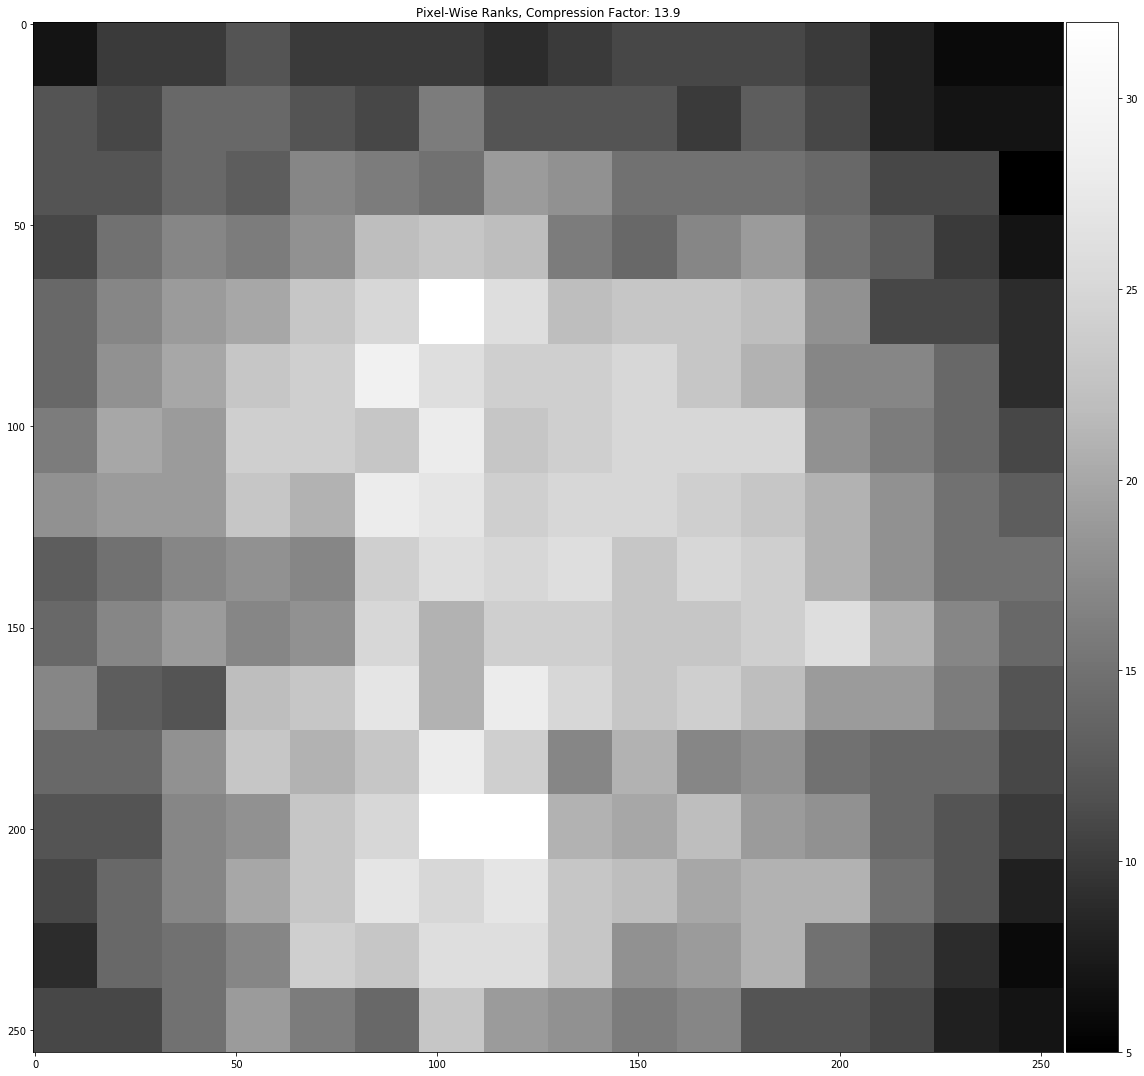

In [34]:
pixelwise_ranks(block_ranks, 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [9.2e-02 9.8e-01]
Local correlation:  range [2.1e-01 1.0e+00]
Local correlation:  range [-2.0e-01 2.2e-02]


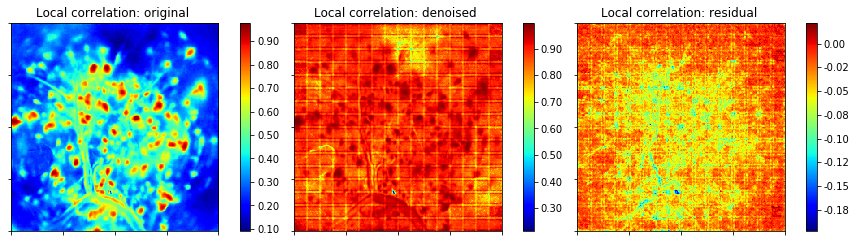

In [35]:
comparison_plot([foreground, denoised_foreground], plot_orientation="vertical")

## Generate Paper Figs

Single Frame:  range [-4.3e+00 1.0e+01]
Single Frame:  range [-3.7e+00 9.6e+00]
Single Frame:  range [-2.7e+00 2.9e+00]
SNR:  range [1.2e+00 7.6e+00]
SNR:  range [1.7e+00 1.1e+01]
SNR:  range [1.1e+00 1.3e+00]
Local correlation:  range [1.1e-01 9.8e-01]
Local correlation:  range [-1.6e-01 9.6e-03]


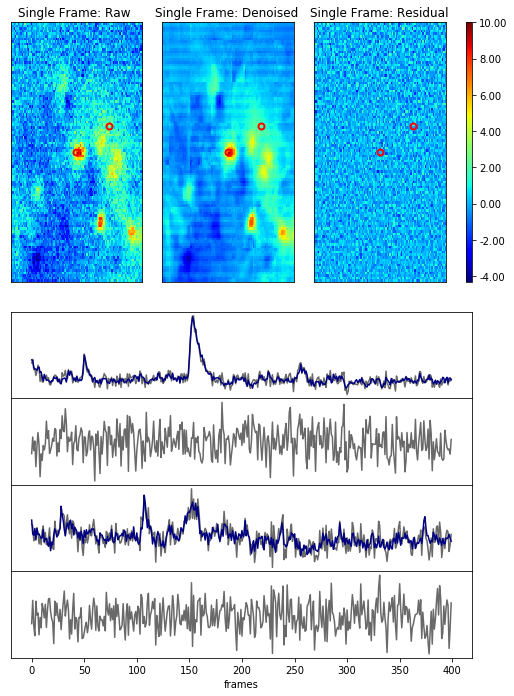

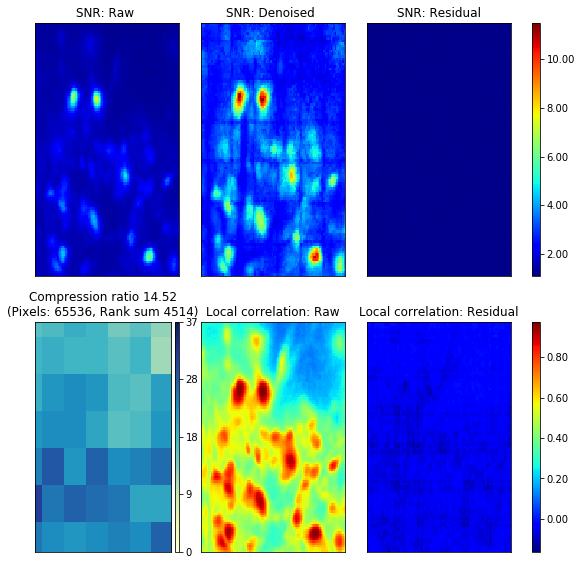

In [36]:
mpdf_plot.pdf_write(foreground,
                    denoised_foreground,
                    ranks=block_ranks,
                    pixel_coor1=[75, 125],
                    pixel_coor2=[85, 150],
                    frame_idx=756,
                    trace_seg=[600,1000],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='Endoscope_PMD.pdf')
plt.show()

In [37]:
del foreground, denoised_foreground

# Dendritic

In [38]:
dataset = "Dendritic"
filename = os.path.join(ext, "data", "xp33_60pct_210_192_-1000_rig.npy")
block_height = 42
block_width = 24
d_sub = 1

In [39]:
mov = np.load(filename).astype(np.float64).copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Preprocess

In [40]:
# Remove Any Nan Pixels
mov[np.isnan(mov)] = 0

# Remove Movie-Wise Median
mov -= np.median(mov)

# Normalize By Pixelwise Standard Deviation
pixelwise_std = np.reshape(np.sqrt(psd_noise_estimate(np.reshape(mov, (num_pixels, num_frames)))),
                           (fov_height, fov_width, 1))
mov /= pixelwise_std
mov[np.isnan(mov)] = 0

## Run Decomposition

In [41]:
# Perform 4x Overlapping Blockwise PMD In Parallel
spatial_components,\
temporal_components,\
block_ranks,\
block_indices,\
block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                            mov, block_height, block_width,
                                            max_components, consec_failures,
                                            max_iters_main, max_iters_init, tol,
                                            d_sub=d_sub, t_sub=t_sub)

# Use Compressed Components To Reconstruct Denoise Video
mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                      block_height, block_width,
                                                      spatial_components,
                                                      temporal_components,
                                                      block_ranks,
                                                      block_indices,
                                                      block_weights)) 

## Run Timing Evaluation

In [42]:
def time_dec_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)

timeit.timeit(time_dec_pmd, number=5)/5

2.9765990825995687

## Produce Performance Diagnostics

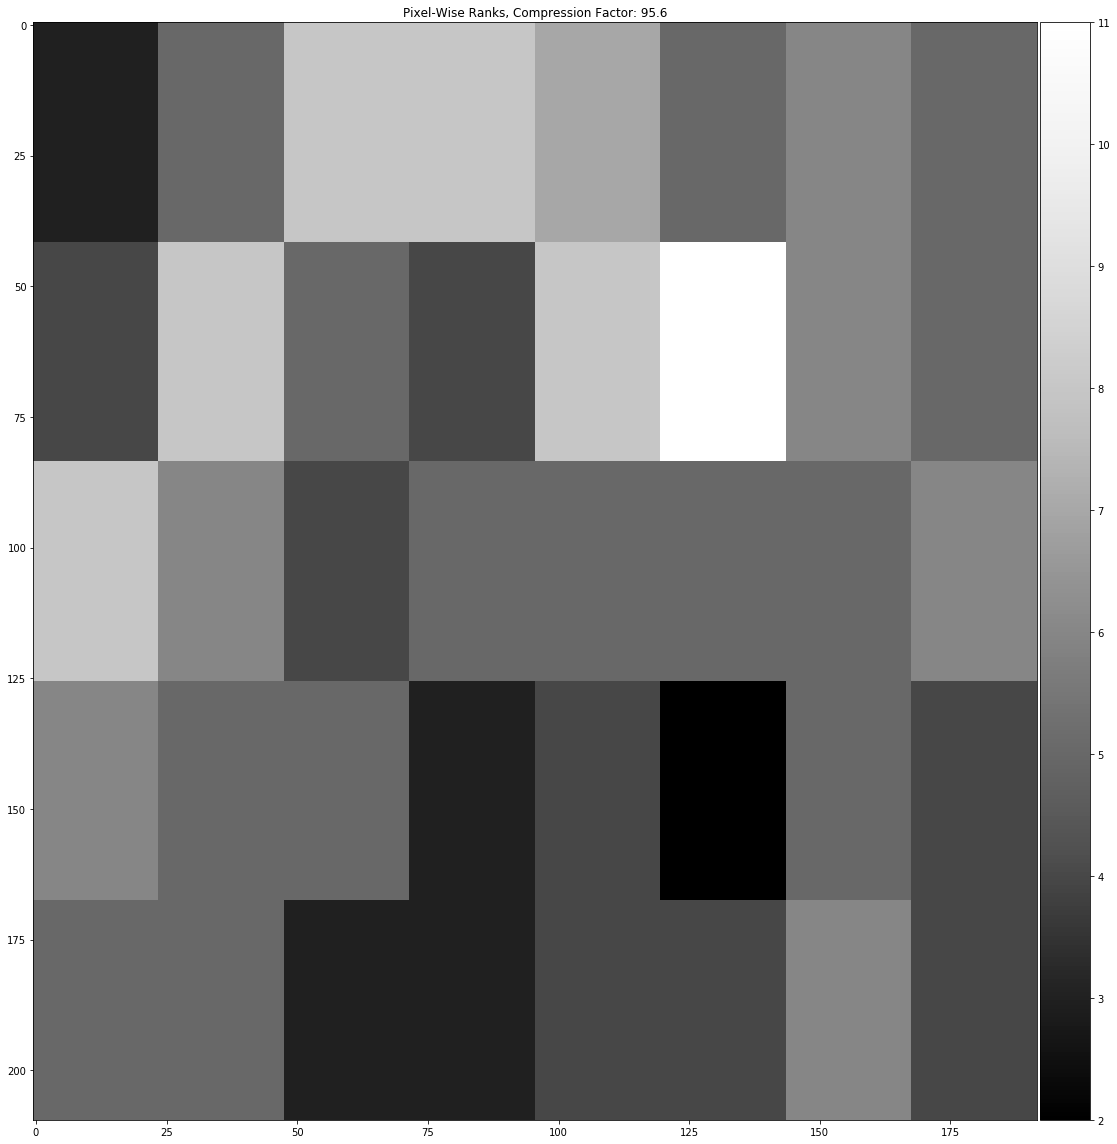

In [43]:
pixelwise_ranks(block_ranks['no_skew']['full'], 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [-3.6e-02 9.0e-01]
Local correlation:  range [-6.7e-01 1.0e+00]
Local correlation:  range [-1.6e-01 1.3e-01]


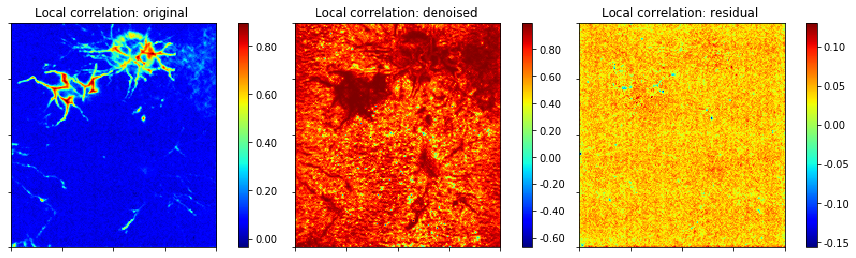

In [44]:
comparison_plot([mov, mov_denoised], plot_orientation="vertical")

## Generate Paper Figs

Single Frame:  range [-1.7e+00 2.3e+01]
Single Frame:  range [-9.7e-01 2.0e+01]
Single Frame:  range [-5.5e+00 6.9e+00]
SNR:  range [1.1e+00 5.7e+00]
SNR:  range [1.3e+00 2.4e+01]
SNR:  range [1.0e+00 2.0e+00]
Local correlation:  range [1.9e-02 9.0e-01]
Local correlation:  range [-1.4e-01 1.3e-01]


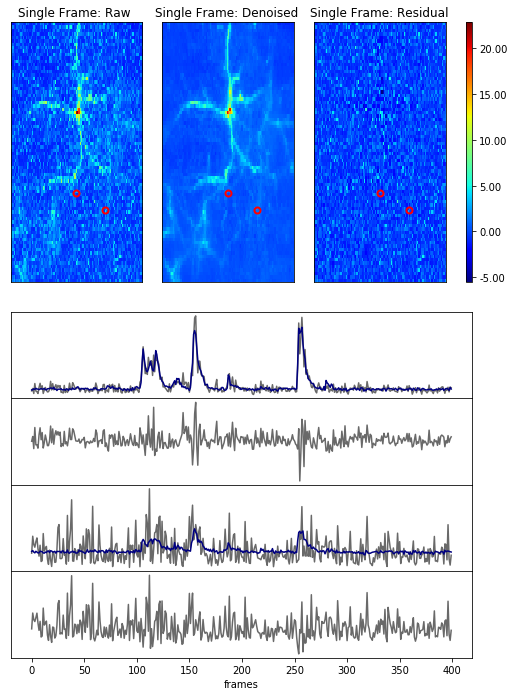

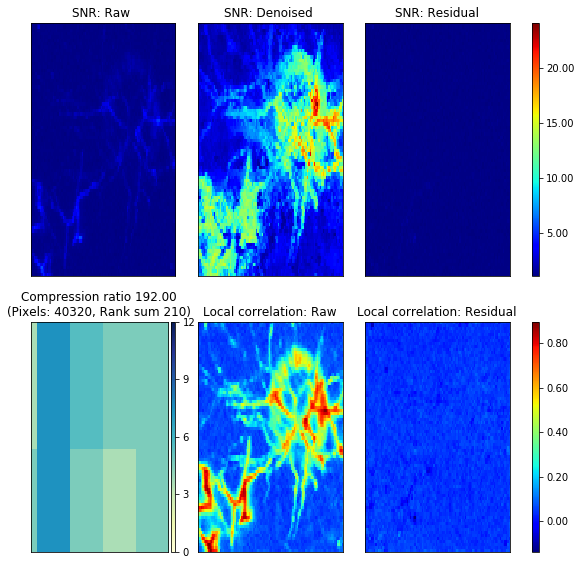

In [45]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks['no_skew']['full'],
                    pixel_coor1=[26, 94],
                    pixel_coor2=[21, 116],
                    frame_idx=756,
                    trace_seg=[600,1000],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='Dendritic_PMD.pdf')
plt.show()